# Required dependencies



In [1]:
!pip install yfinance pyspark==3.5.7 matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.4/317.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.7-py2.py3-none-any.whl size=317907716 sha256=419174619854d0ed135119a428da37dccb2592adae9f6f9752280735385c772a
  Stored in directory: /root/.cache/pip/wheels/f2/d3/02/10ad17f2eeb2cb9c800e320c8ca9ac87d0df8fe3adb8af7e95
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1


In [2]:
!apt-get install openjdk-17-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.7 yfinance matplotlib pandas -q

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

# Imports

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Start Spark session

In [5]:
spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()

Enter the stock symbol (e.g., AAPL, TSLA, MSFT): tatamotors.ns


/tmp/ipython-input-3093027162.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start='2023-01-01', end=today)
[*********************100%***********************]  1 of 1 completed


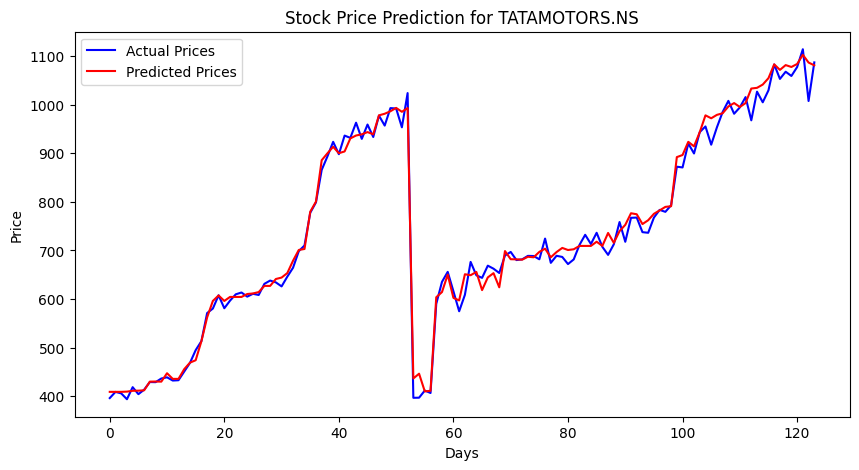


---------------------------------------------
📅 Prediction Date: 2025-11-09
Predicted closing price for TATAMOTORS.NS on 2025-11-09: $409.18
As per the model, the stock is expected to go UP 📈 on 2025-11-09.
---------------------------------------------


In [6]:
# User input for stock symbol
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TSLA, MSFT): ").upper()

# Download stock data (automatically up to today's date)
today = datetime.date.today()
data = yf.download(stock_symbol, start='2023-01-01', end=today)

# Fix nested column names (like ('Open','MSFT'))
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]  # keep only first level
data.reset_index(inplace=True)

# Keep and rename needed columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add new features
data['Price_Change'] = data['Close'] - data['Open']
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['Target'] = data['Close'].shift(-1)  # next-day close price
data.dropna(inplace=True)

# Convert pandas → Spark DataFrame
df = spark.createDataFrame(data)

# Rename Spark columns neatly (your preferred way)
new_column_names = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Price_Change', 'MA5', 'MA10', 'Target'
]

for old_col, new_col in zip(df.columns, new_column_names):
    df = df.withColumnRenamed(old_col, new_col)

# Create feature vector
assembler = VectorAssembler(
    inputCols=['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'MA5', 'MA10'],
    outputCol='features'
)
data_spark = assembler.transform(df).select('features', 'Target')

# Split data into training/testing
train, test = data_spark.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Target', numTrees=50)
model = rf.fit(train)

# Make predictions
predictions = model.transform(test).toPandas()

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(predictions['Target'].values, label='Actual Prices', color='blue')
plt.plot(predictions['prediction'].values, label='Predicted Prices', color='red')
plt.title(f"Stock Price Prediction for {stock_symbol}")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

# Tomorrow's prediction summary
# Get the latest data point
latest_data = data.iloc[-1]
latest_features = [[
    latest_data['Open'], latest_data['High'], latest_data['Low'],
    latest_data['Close'], latest_data['Volume'],
    latest_data['Price_Change'], latest_data['MA5'], latest_data['MA10']
]]

# Convert to Spark DataFrame for prediction
latest_df = spark.createDataFrame(pd.DataFrame(latest_features, columns=[
    'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'MA5', 'MA10'
]))
latest_spark = assembler.transform(latest_df)
future_pred = model.transform(latest_spark).toPandas()['prediction'].iloc[0]

# Display tomorrow's date and prediction
tomorrow = today + datetime.timedelta(days=1)
current_close = latest_data['Close']

print("\n---------------------------------------------")
print(f"📅 Prediction Date: {tomorrow}")
print(f"Predicted closing price for {stock_symbol} on {tomorrow}: ${future_pred:.2f}")

if future_pred > current_close:
    print(f"As per the model, the stock is expected to go UP 📈 on {tomorrow}.")
else:
    print(f"As per the model, the stock might go DOWN 📉 on {tomorrow}.")
print("---------------------------------------------")
